In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

import datetime
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import textwrap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn import tree


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)


In [2]:
df = pd.read_csv("../data/viewing_rating.csv", encoding='cp932')

In [3]:
# time型に
df.start_at=pd.to_datetime(df.start_at)
# averageの％を削除
df["average"] =  df["average"].apply(lambda x : float(x[:-1]) )


In [4]:
df["start_at_year"] = df["start_at"].dt.year
df["start_at_month"] = df["start_at"].dt.month

In [5]:
df["drama_key"] = df.start_at.dt.strftime("%y")+df.start_at.dt.strftime("%m")+"_"+df.TV_station+"_"+df.time_table

In [6]:
import json

f = open("../data/drama_info0115.json", 'r')
print(f)
drama_info_json = json.load(f)

<_io.TextIOWrapper name='../data/drama_info0115.json' mode='r' encoding='UTF-8'>


In [7]:
# def addDramaInfo (drama_title) 
#     main_actor_only_json[drama_title]
    


In [8]:
print (textwrap.shorten(str(drama_info_json), 1000))

{'1910_CX_月21': {'main_actor1': 'ディーン・フジオカ', 'main_actor2': '岩田剛典', 'original_work': 'アーサー・コナン・ドイル「シャーロック・ホームズ」'}, '1910_CX_火22': {'main_actor1': '阿部寛', 'main_actor2': '吉田羊', 'original_work': ''}, '1910_TBS_火22': {'main_actor1': '波瑠', 'main_actor2': '中川大志', 'original_work': 'いくえみ綾「G線上のあなたと私」'}, '1910_NTV_水22': {'main_actor1': '高畑充希', 'main_actor2': '橋本愛', 'original_work': ''}, '1910_EX_木21': {'main_actor1': '米倉涼子', 'main_actor2': 'ユースケ・サンタマリア', 'original_work': ''}, '1910_CX_木22': {'main_actor1': '新木優子', 'main_actor2': '高良健吾', 'original_work': '瀧波ユカリ「モトカレマニア」'}, '1910_NTV_木23': {'main_actor1': '本田翼', 'main_actor2': '金子大地', 'original_work': ''}, '1910_TBS_金22': {'main_actor1': '福士蒼汰', 'main_actor2': '菜々緒', 'original_work': 'キリエ「4分間のマリーゴールド」'}, '1910_EX_金23': {'main_actor1': 'オダギリジョー', 'main_actor2': '麻生久美子', 'original_work': ''}, '1910_NTV_土22': {'main_actor1': '生田斗真', 'main_actor2': '安田顕', 'original_work': ''}, '1910_EX_土23': {'main_actor1': '田中圭', 'main_actor2': '吉田鋼太郎', [...]


In [9]:
df["main_actor1"] = ""
df["main_actor2"] = ""
df["original_work"] = ""

In [10]:
for tmp_index in range(len(df)):
    tmp_drama_key = df.iloc[tmp_index]["drama_key"]
    if tmp_drama_key in drama_info_json.keys():
#         print(drama_info_json[tmp_drama_key]["main_actor1"])
        df["main_actor1"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor1"]
        df["main_actor2"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor2"]
        df["original_work"][tmp_index] = drama_info_json[tmp_drama_key]["original_work"]
#         print("yes"+tmp_drama_title)
    else:
        print(tmp_drama_key)

In [11]:
def make_person_key_df (actor_actress):
    actor_actress_list = []
    for column in actor_actress.columns:
        if column == "ranking":
            continue
        actor_actress_list.extend(actor_actress[column].values.tolist())
    print ("元の数"+ str(len(actor_actress_list)))
    # uniqueにする
    actor_actress_list = list(set(actor_actress_list))
    #nan を除去
    actor_actress_list = [actor for actor in actor_actress_list if type(actor) is not float ]
    print ("後の数"+str(len(actor_actress_list)))

    df_pivot = pd.DataFrame( columns=actor_actress_list, index=[str(n) for n in range(2008,2020)])

    #pivot 形式に整形する
    for tmp_name in df_pivot.columns:
        for year in actor_actress.columns:
            if year == "ranking": continue
            if  len(actor_actress[actor_actress[year] == tmp_name].ranking) > 0:
                df_pivot.loc[year][tmp_name] = (actor_actress[actor_actress[year] == tmp_name].ranking).values[0]
    return (df_pivot)
    

In [12]:
df_actress = pd.read_csv("../data/actress_power.csv", encoding='cp932')
df_actress_pivot = make_person_key_df(df_actress)


元の数360
後の数69


In [13]:
df_actor = pd.read_csv("../data/actor_power.csv", encoding='cp932')
df_actor_pivot = make_person_key_df(df_actor)

元の数372
後の数69


In [14]:
df_actress_pivot

,木村佳乃,黒木メイサ,薬師丸ひろ子,永作博美,蒼井優,常盤貴子,綾瀬はるか,長澤まさみ,上戸,藤原紀香,江角マキコ,芦田愛菜,香里奈,井上真央,新垣結衣,篠原涼子,上野樹里,菅野美穂,小雪,柴崎コウ,小泉今日子,松たか子,竹内結子,戸田恵梨香,吉田羊,宮_あおい,天海祐希,杏,榮倉奈々,松嶋菜々子,樹木希林,上戸彩,北川景子,深田恭子,菜々緒,柴咲コウ,桐谷美玲,石田ゆり子,吉高由里子,高畑充希,佐々木希,観月ありさ,松雪泰子,土屋太鳳,剛力彩芽,吉瀬美智子,松,山口智子,有村架純,波瑠,石原さとみ,広瀬アリス,黒木瞳,吉永小百合,真矢みき,深津絵里,広瀬すず,木村文乃,宮崎あおい,松下奈緒,仲間由紀恵,米倉涼子,橋本環奈,優香,多部未華子,武井咲,堀北真希,能年玲奈,武井
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,NaN,23,NaN,NaN,26,24,6,17,NaN,27,NaN,NaN,NaN,28,9,21,NaN,5,30,NaN,NaN,16,8,25,NaN,10,1,NaN,NaN,3,NaN,4,NaN,20,NaN,7,NaN,NaN,NaN,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,14,22,18,13,NaN,NaN,NaN,NaN,2,19,NaN,12,NaN,NaN,15,NaN,NaN
2011,NaN,7,NaN,29,25,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,27,10,12,18,1,NaN,NaN,16,19,13,NaN,NaN,9,6,NaN,NaN,8,NaN,3,15,17,NaN,4,NaN,NaN,NaN,NaN,NaN,24,NaN,NaN,NaN,NaN,NaN,28,NaN,NaN,21,NaN,30,22,20,11,NaN,NaN,NaN,23,5,26,NaN,NaN,NaN,NaN,14,NaN,NaN
2012,NaN,NaN,NaN,NaN,NaN,28,2,12,6,NaN,17,20,25,13,7,15,NaN,9,NaN,NaN,22,NaN,8,NaN,NaN,NaN,3,NaN,NaN,1,NaN,NaN,18,21,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN,24,NaN,NaN,NaN,23,NaN,NaN,29,27,11,NaN,NaN,16,NaN,4,26,NaN,14,NaN,NaN,5,NaN,19
2013,NaN,NaN,29,NaN,NaN,23,1,17,NaN,NaN,15,NaN,NaN,20,9,10,NaN,6,NaN,NaN,21,NaN,25,NaN,NaN,NaN,3,NaN,NaN,5,18,4,14,13,NaN,8,NaN,NaN,28,NaN,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,27,22,16,NaN,NaN,24,NaN,7,11,NaN,12,NaN,26,2,NaN,NaN
2014,NaN,NaN,28,NaN,NaN,NaN,1,22,NaN,NaN,20,NaN,NaN,17,5,14,NaN,6,NaN,NaN,11,23,NaN,NaN,NaN,30,9,15,NaN,12,24,3,4,18,NaN,7,NaN,NaN,NaN,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,19,NaN,27,NaN,NaN,NaN,29,10,13,NaN,16,NaN,21,2,25,NaN
2015,NaN,NaN,NaN,NaN,NaN,NaN,1,22,NaN,NaN,NaN,NaN,NaN,20,5,13,30,15,NaN,NaN,24,11,16,NaN,NaN,NaN,8,7,NaN,14,NaN,10,4,18,NaN,6,29,NaN,26,NaN,21,NaN,NaN,NaN,NaN,27,NaN,NaN,NaN,NaN,12,NaN,NaN,25,NaN,28,NaN,NaN,NaN,NaN,3,9,NaN,19,NaN,23,2,17,NaN
2016,NaN,NaN,NaN,NaN,NaN,NaN,1,22,NaN,NaN,NaN,NaN,NaN,30,4,14,NaN,18,NaN,NaN,19,17,26,NaN,16,29,7,11,NaN,21,NaN,12,2,8,27,13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,5,NaN,NaN,25,NaN,28,15,NaN,NaN,NaN,9,20,NaN,24,NaN,23,6,NaN,NaN
2017,NaN,NaN,NaN,NaN,NaN,NaN,2,16,NaN,NaN,NaN,NaN,NaN,28,1,10,NaN,17,NaN,13,27,NaN,29,NaN,NaN,NaN,8,14,26,22,NaN,12,4,5,NaN,NaN,9,20,21,NaN,30,NaN,NaN,19,NaN,NaN,NaN,NaN,6,NaN,3,NaN,NaN,NaN,NaN,25,11,NaN,NaN,NaN,7,18,NaN,NaN,24,23,15,NaN,NaN


In [15]:
df_actor_namekey = df_actor_pivot.T.rename_axis('actor_actress').reset_index()

In [16]:
df_actress_namekey = df_actress_pivot.T.rename_axis('actor_actress').reset_index()

In [17]:
df_actress_namekey

,actor_actress,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,木村佳乃,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
1,黒木メイサ,NaN,NaN,23,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,薬師丸ひろ子,NaN,NaN,NaN,NaN,NaN,29,28,NaN,NaN,NaN,NaN,29
3,永作博美,NaN,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,蒼井優,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,常盤貴子,NaN,NaN,24,NaN,28,23,NaN,NaN,NaN,NaN,NaN,NaN
6,綾瀬はるか,NaN,NaN,6,2,2,1,1,1,1,2,1,1
7,長澤まさみ,NaN,NaN,17,NaN,12,17,22,22,22,16,9,8
8,上戸,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,藤原紀香,NaN,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_merged = pd.merge(df, df_actor_namekey,left_on='main_actor1', right_on='actor_actress', how='left')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='right')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='right')

In [19]:

df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='left'
                     ,suffixes=('_1', '_2'))

In [20]:

df_merged = pd.merge(df_merged, df_actor_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                     ,suffixes=('_3', '_4') )


In [21]:
df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                    , suffixes=('_3', '_4'),)

In [22]:
# df_merged[["main_actor1","2017","2016","2014"]]
df_merged

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,TBS,木22,年下の男,11.8,10.7,12.2,11.8,12.6,12.6,13.7,13.5,14.1,14.2,13.3,-,-,-,-,12.77,2005/4/1,2003-01-01,2003,1,0301_TBS_木22,稲森いずみ,高橋克典,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,CX,木22,美女か野獣,20.0,17.3,18.6,18.6,17.3,17.5,17,19,19.4,18.9,19.4,-,-,-,-,18.45,2005/4/1,2003-01-01,2003,1,0301_CX_木22,松嶋菜々子,福山雅治,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,松嶋菜々子,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,TBS,金22,高校教師,14.9,12.2,6.4,10.7,10.6,8.8,10.2,13.5,11.2,8.8,11,-,-,-,-,10.75,4-6-0,2003-01-01,2003,1,0301_TBS_金22,藤木直人,上戸彩,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,上戸彩,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NTV,土21,よい子の味方,13.4,10.2,8.9,10.0,10.1,7.5,11.1,10.7,12,-,-,-,-,-,-,10.43,4-4-0,2003-01-01,2003,1,0301_NTV_土21,櫻井翔,松下由樹,,櫻井翔,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_merged

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,TBS,木22,年下の男,11.8,10.7,12.2,11.8,12.6,12.6,13.7,13.5,14.1,14.2,13.3,-,-,-,-,12.77,2005/4/1,2003-01-01,2003,1,0301_TBS_木22,稲森いずみ,高橋克典,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,CX,木22,美女か野獣,20.0,17.3,18.6,18.6,17.3,17.5,17,19,19.4,18.9,19.4,-,-,-,-,18.45,2005/4/1,2003-01-01,2003,1,0301_CX_木22,松嶋菜々子,福山雅治,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,松嶋菜々子,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,TBS,金22,高校教師,14.9,12.2,6.4,10.7,10.6,8.8,10.2,13.5,11.2,8.8,11,-,-,-,-,10.75,4-6-0,2003-01-01,2003,1,0301_TBS_金22,藤木直人,上戸彩,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,上戸彩,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NTV,土21,よい子の味方,13.4,10.2,8.9,10.0,10.1,7.5,11.1,10.7,12,-,-,-,-,-,-,10.43,4-4-0,2003-01-01,2003,1,0301_NTV_土21,櫻井翔,松下由樹,,櫻井翔,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_merged.loc[:,df_merged.columns.str.contains('20')]

,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,26,26,11,13,9,20,18,15,12,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
df_new4years = df_merged[df_merged["start_at"] > datetime.datetime.strptime("2011-01-01", '%Y-%m-%d')]

In [74]:
df_new4years

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,EX,金23,犬を飼うということ,9.3,8.3,7.8,8.6,9.4,7.4,8.1,8.3,9,-,-,-,-,-,-,8.47,5-3-0,2011-04-01,2011,4,1104_EX_金23,錦戸亮,水川あさみ,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
494,NTV,土21,高校生レストラン,13.1,11.2,10.9,11.3,11.5,8.7,10.2,9.5,9.7,-,-,-,-,-,-,10.75,4-4-0,2011-04-01,2011,4,1104_NTV_土21,松岡昌宏,吹石一恵,村林新吾「高校生レストラン､本日も満席｡」「高校生レストラン､行列の理由｡」,松岡昌宏,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,NaN,30,27,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
495,TBS,日21,JIN -仁-,23.7,18.4,20.4,20.7,20.8,18.8,18.8,18.7,19.2,21.2,26.1,-,-,-,-,21.28,2006/3/1,2011-04-01,2011,4,1104_TBS_日21,大沢たかお,綾瀬はるか,村上もとか「JIN -仁-」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,綾瀬はるか,NaN,NaN,6,2,2,1,1,1,1,2,1,1
496,CX,日21,マルモのおきて,11.6,12.9,12.3,12.7,15.6,15.6,16.1,16.8,17.2,15.6,23.9,-,-,-,-,15.76,2007/2/1,2011-04-01,2011,4,1104_CX_日21,阿部サダヲ,芦田愛菜,,阿部サダヲ,NaN,NaN,NaN,NaN,7,11,11,16,14,9,6,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [75]:
df_new4years["main_actor1_rank"] = np.nan
df_new4years["main_actor2_rank"] = np.nan



In [76]:
for i in range(len(df_new4years)):
    #print(df_new4years.iloc[i])
#     print(df_new4years.iloc[i]["start_at"])
    prev_year = df_new4years["start_at"].dt.year.iloc[i] - 1 
    df_filter = df_new4years.loc[:,df_new4years.columns.str.contains(str(prev_year))]
#   import pdb;pdb.set_trace()
    
    prev_year1 = str(prev_year) + "_1"
    prev_year2 = str(prev_year) + "_2"
    prev_year3 = str(prev_year) + "_3"
    prev_year4 = str(prev_year) + "_4"
#     import pdb; pdb.set_trace()
    for j in range(len(df_filter)):
        tmp1 =  0 if np.isnan(df_filter[prev_year1].iloc[j]) else df_filter[prev_year1].iloc[j]
        tmp2 =  0 if np.isnan(df_filter[prev_year2].iloc[j]) else df_filter[prev_year2].iloc[j]
        tmp3 =  0 if np.isnan(df_filter[prev_year3].iloc[j]) else df_filter[prev_year3].iloc[j]
        tmp4 =  0 if np.isnan(df_filter[prev_year4].iloc[j]) else df_filter[prev_year4].iloc[j]
#         import pdb; pdb.set_trace()
        df_new4years["main_actor1_rank"].iloc[j] =   tmp1 + tmp2 if (tmp1 + tmp2 != 0) else np.nan
        df_new4years["main_actor2_rank"].iloc[j] =   tmp3 + tmp4 if (tmp3 + tmp4 != 0) else np.nan
#         print(dbg)
#     df_filter[prev_year + "_2"]
#    if  np.isnan(df_filter["2018_1"]) or np.isnan(df_filter["2018_2"])  :
#        print("come")

In [77]:
df_new4years["main_actor1_rank"]

0       NaN
1      11.0
2       NaN
3       NaN
4      19.0
       ... 
493     NaN
494     NaN
495     NaN
496     NaN
497     NaN
Name: main_actor1_rank, Length: 498, dtype: float64

In [78]:
df_new4years["main_actor2_rank"]

0       NaN
1       NaN
2       NaN
3       NaN
4      25.0
       ... 
493     NaN
494     NaN
495     6.0
496     NaN
497     NaN
Name: main_actor2_rank, Length: 498, dtype: float64

In [79]:
df_episode = df_new4years.loc[:, df_new4years.columns.str.contains("Epi")]

In [80]:
df_new4years["average_calc"] = np.nan

In [81]:
# averageを計算してみたが、もともとあるaverageが加重平均だったので、そちらを採用することに
for i in  range(len(df_episode)):
    vr_sum = 0
    for epi_i, col in  enumerate(df_episode.columns):
#         print(str(df_new4years[col].iloc[i] )+ "__"+str(vr_sum) +"_"+str(epi_i) + "index"+str(i))
        if df_episode[col].iloc[i] == "-"  :
            if epi_i == 0:
#                 print (col+"_"+str(epi_i))
                break
            df_new4years["average_calc"].iloc[i] = vr_sum/epi_i
            break
#            df_new4years["average_calc"].iloc[i] = vr_sum/i
        vr_sum += float(df_episode[col].iloc[i])
        if epi_i == 14 : df_new4years["average_calc"].iloc[i] = vr_sum / 15
        
        #df_new4years.iloc[i]
    

## CM数も特徴量に

In [82]:
df_cm = pd.read_csv("../data/number_of_cm.csv", encoding='cp932')

In [83]:
df_cm["name_ns"] = df_cm.name.str.replace('\s','')

In [84]:
df_cm_pivot = pd.DataFrame(index = set(df_cm.name_ns.values),columns = range(1990,2019)  )

In [85]:
for t_name in set(df_cm.name_ns.values):
    for t_year in range(1990,2019):
        
#         tmp_q = f"name_ns == '{t_name}' & year == '{t_year}' " 
        tmp_q = "name_ns == @t_name & year == @t_year " 
# print(tmp_q)
        try :
            tmp_df = df_cm.query(tmp_q)
    #             print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
            if tmp_df["number_of_cm"].values:
#                 print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
                df_cm_pivot.loc[t_name,t_year] = int(tmp_df["number_of_cm"].values)
        except KeyError as instance:
            print (instance)
        
        

In [86]:
df_cm_pivot = df_cm_pivot.rename_axis("actor_actress").reset_index()

In [87]:
rank_arr = df_actor_namekey.actor_actress.values.tolist()

In [88]:
rank_arr.extend(df_actress_namekey.actor_actress.values)

In [89]:
### 表示の確認
# for t_n in df_cm_pivot["actor_actress"].values:
#     if t_n in rank_arr: print(t_n)
    

# 特徴量エンジニアリング

### 俳優ランクを人気ポイントに

In [90]:
df_new4years["main_actor1_pt"] = df_new4years["main_actor1_rank"].apply(lambda x : 40 - x )

In [91]:
df_new4years["main_actor2_pt"] = df_new4years["main_actor2_rank"].apply(lambda x : 40 - x )

In [92]:
df_new4years["main_actor1_pt"] = df_new4years["main_actor1_pt"].fillna(0)
df_new4years["main_actor2_pt"] = df_new4years["main_actor2_pt"].fillna(0)

In [93]:
df_new4years["has_original_work"] = df_new4years["original_work"].apply(lambda x : "" if x =="" else True ) 

### (TODO) CM数も特徴量に加工する

### one hotエンコーディング

In [94]:
df_new4years = pd.get_dummies(df_new4years, columns=["TV_station", "start_at_month", "start_at_year","has_original_work"] )

## wikiの俳優情報を特徴量として

In [109]:
f = open("../data/actor_wiki0220.json", 'r')
print(f)
actor_wiki_json = json.load(f)

<_io.TextIOWrapper name='../data/actor_wiki0220.json' mode='r' encoding='UTF-8'>


In [111]:
df_new4years["actor1_office"] = np.nan
df_new4years["actor2_office"] = np.nan
df_new4years["actor1_birthday"] = np.nan
df_new4years["actor2_birthday"] = np.nan

In [117]:
for idx in range(len(df_new4years)):
    actor1 = df_new4years["main_actor1"].iloc[idx]
    actor2 = df_new4years["main_actor2"].iloc[idx]
#     print(actor1)
    
    if actor_wiki_json[actor1]:
    
        df_new4years["actor1_office"].iloc[idx] = actor_wiki_json[actor1].get("office")
        df_new4years["actor1_birthday"].iloc[idx] = actor_wiki_json[actor1].get("birthday")
    
    if actor_wiki_json[actor2]:
        df_new4years["actor2_office"].iloc[idx] = actor_wiki_json[actor2].get("office")
        df_new4years["actor2_birthday"].iloc[idx] = actor_wiki_json[actor2].get("birthday")
        
        #     df_new4years[""]
    
    

In [120]:
df_new4years

,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,main_actor1_pt,main_actor2_pt,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2011,start_at_year_2012,start_at_year_2013,start_at_year_2014,start_at_year_2015,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_,actor1_office,actor2_office,actor1_birthday,actor2_birthday
0,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.772727,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,アミューズ,LDH JAPAN,1980-08-19,NaN
1,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27,11.0,NaN,9.340000,29.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,茂田オフィス,ORANKU（おらんく）（ - 2018年）,None,NaN
2,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.650000,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,ホリエージェンシー,NaN,1991-06-17,NaN
3,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.890000,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,ホリプロ,NaN,1991-12-14,NaN
4,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,25.0,18.390000,21.0,15.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,オスカープロモーション,ジャパン・ミュージックエンターテインメント,1975-08-01,1971-03-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,金23,犬を飼うということ,9.3,8.3,7.8,8.6,9.4,7.4,8.1,8.3,9,-,-,-,-,-,-,8.47,5-3-0,2011-04-01,1104_EX_金23,錦戸亮,水川あさみ,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.466667,0

### モデル作成

In [95]:
lm = LinearRegression()

In [96]:
y = df_new4years["average"]

In [97]:
df_new4years

,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,main_actor1_pt,main_actor2_pt,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2011,start_at_year_2012,start_at_year_2013,start_at_year_2014,start_at_year_2015,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_
0,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.772727,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
1,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27,11.0,NaN,9.340000,29.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.650000,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
3,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.890000,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
4,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,25.0,18.390000,21.0,15.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,金23,犬を飼うということ,9.3,8.3,7.8,8.6,9.4,7.4,8.1,8.3,9,-,-,-,-,-,-,8.47,5-3-0,2011-04-01,1104_EX_金23,錦戸亮,水川あさみ,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.466667,0.0,0.0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
494,土21,高校生レストラン,13.1,11.2,10.9,11.3,11.5,8.7,10.2,9.5,9.7,-,-,-,-,-,-,10.75,4-4-0,2011-04-01,1104_NTV_土21,松岡昌宏,吹石一恵,村林新吾「高校生レストラン､本日も満席｡」「高校生レストラン､行列の理由｡」,松岡昌宏,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,NaN,30,27,29,NaN,N

In [98]:
X = df_new4years[["main_actor1_pt" , "main_actor2_pt"]]

In [99]:
X_dummys = df_new4years.loc[:,df_new4years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_|has_original_work'))]

In [100]:
# arr = df_new4years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_'))
# df_cm["name_ns"]


In [101]:
# df_new4years.loc[:, arr]

In [102]:
X_dummys

,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2011,start_at_year_2012,start_at_year_2013,start_at_year_2014,start_at_year_2015,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
494,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
495,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
496,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1


In [103]:
X = pd.concat([X,X_dummys], axis=1)


,main_actor1_pt,main_actor2_pt,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2011,start_at_year_2012,start_at_year_2013,start_at_year_2014,start_at_year_2015,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_
0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
1,29.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
3,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
4,21.0,15.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0.0,0.0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
494,0.0,0.0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
495,0.0,34.0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
496,0.0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1


### モデル作成

In [104]:
y = df_new4years["average"]

In [57]:
lm = LinearRegression()

In [58]:
 X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234 )

In [59]:
model=lm.fit(X_train,y_train)
#predictions=model.predict(x_test)

In [60]:
y_pred = lm.predict(X_test)

In [61]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [62]:
print(lm_rmse)

2.9604912159900314


In [63]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 3.47   	 予測 7.021546541400512 
視聴率：実際 11.47   	 予測 6.352161653783981 
視聴率：実際 11.39   	 予測 7.396788596182736 
視聴率：実際 4.99   	 予測 7.128241021295238 
視聴率：実際 7.73   	 予測 11.866436198741532 
視聴率：実際 10.11   	 予測 9.987093146255503 
視聴率：実際 7.05   	 予測 11.368194401182878 
視聴率：実際 10.66   	 予測 9.8137407012876 
視聴率：実際 4.51   	 予測 7.498944604111174 
視聴率：実際 3.99   	 予測 7.8086949687927945 
視聴率：実際 8.71   	 予測 7.139310081176264 
視聴率：実際 8.77   	 予測 12.016453608100228 
視聴率：実際 5.8   	 予測 6.554378512526811 
視聴率：実際 8.87   	 予測 6.164853796541788 
視聴率：実際 9.14   	 予測 6.352161653783981 
視聴率：実際 9.82   	 予測 6.4956239057017715 
視聴率：実際 3.45   	 予測 7.181593226545596 
視聴率：実際 6.71   	 予測 6.755187766765921 
視聴率：実際 15.24   	 予測 8.964594191692646 
視聴率：実際 8.79   	 予測 8.859790024152048 
視聴率：実際 3.45   	 予測 7.736058572492795 
視聴率：実際 6.92   	 予測 9.213446115860137 
視聴率：実際 3.09   	 予測 5.721976875306406 
視聴率：実際 4.46   	 予測 7.3519362580824525 
視聴率：実際 3.48   	 予測 8.122613224019027 
視聴率：実際 6.14   	 予測 6.111501591291429 
視聴率：

In [64]:
for i in range (len (X.columns)):
    print(f"""{i}  回帰係数 {X.columns[i]}\t{model.coef_[i]} """)

0  回帰係数 main_actor1_pt	0.10226566580484915 
1  回帰係数 main_actor2_pt	0.08221638543783547 
2  回帰係数 TV_station_CX	-0.366230202397147 
3  回帰係数 TV_station_EX	-0.22983228268343 
4  回帰係数 TV_station_NTV	-0.7557549183821702 
5  回帰係数 TV_station_TBS	1.3518174034627475 
6  回帰係数 start_at_month_1	-0.6534805668341196 
7  回帰係数 start_at_month_4	0.13366786055816315 
8  回帰係数 start_at_month_7	-0.21060364559873762 
9  回帰係数 start_at_month_10	0.7304163518746941 
10  回帰係数 start_at_year_2016	-0.15492187064859078 
11  回帰係数 start_at_year_2017	0.26152297392775514 
12  回帰係数 start_at_year_2018	0.018430574319313015 
13  回帰係数 start_at_year_2019	-0.1250316775984777 
14  回帰係数 has_original_work_True	-0.386823515197683 
15  回帰係数 has_original_work_	0.38682351519768293 


In [65]:
print('モデル関数の切片 w2: %.3f' %model.intercept_)

モデル関数の切片 w2: 7.500


In [66]:
print('決定係数 R^2： ', model.score(X, y))

決定係数 R^2：  0.30795153054847046


# モデル２決定木

In [67]:
# clf = DecisionTreeRegressor(max_depth = 3)
clf = DecisionTreeRegressor(max_leaf_nodes= 14)
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=14, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [68]:
y_pred_tree = clf.predict(X_test)

In [69]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print (lm_rmse)

3.578426551650065


In [70]:
for i in range (len (X.columns)):
    print(f"""{i}  FI {X.columns[i]}     \t{clf.feature_importances_[i]} """)


0  FI main_actor1_pt     	0.666157211564085 
1  FI main_actor2_pt     	0.0651645802777761 
2  FI TV_station_CX     	0.02292816828625581 
3  FI TV_station_EX     	0.022018455556071726 
4  FI TV_station_NTV     	0.0 
5  FI TV_station_TBS     	0.1477717418920473 
6  FI start_at_month_1     	0.0 
7  FI start_at_month_4     	0.015668648557302402 
8  FI start_at_month_7     	0.0 
9  FI start_at_month_10     	0.022361542731363687 
10  FI start_at_year_2016     	0.0 
11  FI start_at_year_2017     	0.019381724087015596 
12  FI start_at_year_2018     	0.0 
13  FI start_at_year_2019     	0.0 
14  FI has_original_work_True     	0.01854792704808233 
15  FI has_original_work_     	0.0 


In [71]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 3.47   	 予測 7.021546541400512 
視聴率：実際 11.47   	 予測 6.352161653783981 
視聴率：実際 11.39   	 予測 7.396788596182736 
視聴率：実際 4.99   	 予測 7.128241021295238 
視聴率：実際 7.73   	 予測 11.866436198741532 
視聴率：実際 10.11   	 予測 9.987093146255503 
視聴率：実際 7.05   	 予測 11.368194401182878 
視聴率：実際 10.66   	 予測 9.8137407012876 
視聴率：実際 4.51   	 予測 7.498944604111174 
視聴率：実際 3.99   	 予測 7.8086949687927945 
視聴率：実際 8.71   	 予測 7.139310081176264 
視聴率：実際 8.77   	 予測 12.016453608100228 
視聴率：実際 5.8   	 予測 6.554378512526811 
視聴率：実際 8.87   	 予測 6.164853796541788 
視聴率：実際 9.14   	 予測 6.352161653783981 
視聴率：実際 9.82   	 予測 6.4956239057017715 
視聴率：実際 3.45   	 予測 7.181593226545596 
視聴率：実際 6.71   	 予測 6.755187766765921 
視聴率：実際 15.24   	 予測 8.964594191692646 
視聴率：実際 8.79   	 予測 8.859790024152048 
視聴率：実際 3.45   	 予測 7.736058572492795 
視聴率：実際 6.92   	 予測 9.213446115860137 
視聴率：実際 3.09   	 予測 5.721976875306406 
視聴率：実際 4.46   	 予測 7.3519362580824525 
視聴率：実際 3.48   	 予測 8.122613224019027 
視聴率：実際 6.14   	 予測 6.111501591291429 
視聴率：

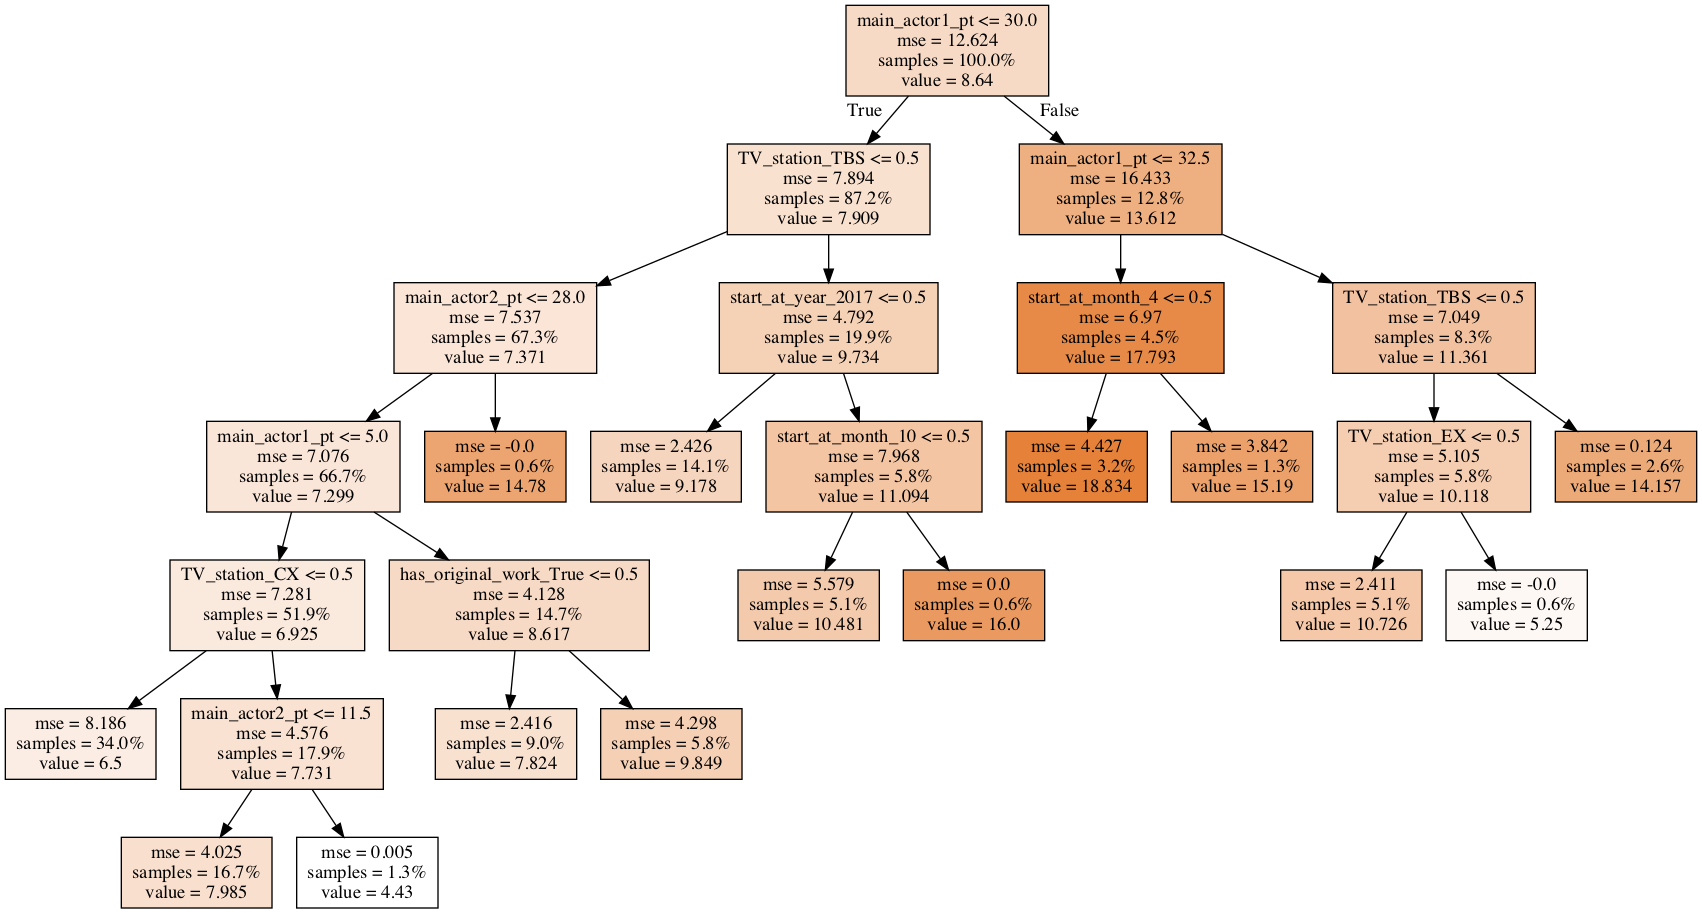

In [72]:
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=X.columns,
    class_names="average",
    filled=True,
    proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())